In [1]:
import nibabel as nib

dlabel_path = "/home/lucas/projects/MULTFSCTRL/prep/fmriprep/Glasser_LR_Dense64k.dlabel.nii"

dl = nib.load(dlabel_path)
label_dict = dl.header.get_axis(0).label[0]

for k, (name, rgba) in sorted(label_dict.items()):
    print(f"{k:4d}  {name}")

   0  ???
   1  L_V1_ROI
   2  L_MST_ROI
   3  L_V6_ROI
   4  L_V2_ROI
   5  L_V3_ROI
   6  L_V4_ROI
   7  L_V8_ROI
   8  L_4_ROI
   9  L_3b_ROI
  10  L_FEF_ROI
  11  L_PEF_ROI
  12  L_55b_ROI
  13  L_V3A_ROI
  14  L_RSC_ROI
  15  L_POS2_ROI
  16  L_V7_ROI
  17  L_IPS1_ROI
  18  L_FFC_ROI
  19  L_V3B_ROI
  20  L_LO1_ROI
  21  L_LO2_ROI
  22  L_PIT_ROI
  23  L_MT_ROI
  24  L_A1_ROI
  25  L_PSL_ROI
  26  L_SFL_ROI
  27  L_PCV_ROI
  28  L_STV_ROI
  29  L_7Pm_ROI
  30  L_7m_ROI
  31  L_POS1_ROI
  32  L_23d_ROI
  33  L_v23ab_ROI
  34  L_d23ab_ROI
  35  L_31pv_ROI
  36  L_5m_ROI
  37  L_5mv_ROI
  38  L_23c_ROI
  39  L_5L_ROI
  40  L_24dd_ROI
  41  L_24dv_ROI
  42  L_7AL_ROI
  43  L_SCEF_ROI
  44  L_6ma_ROI
  45  L_7Am_ROI
  46  L_7PL_ROI
  47  L_7PC_ROI
  48  L_LIPv_ROI
  49  L_VIP_ROI
  50  L_MIP_ROI
  51  L_1_ROI
  52  L_2_ROI
  53  L_3a_ROI
  54  L_6d_ROI
  55  L_6mp_ROI
  56  L_6v_ROI
  57  L_p24pr_ROI
  58  L_33pr_ROI
  59  L_a24pr_ROI
  60  L_p32pr_ROI
  61  L_a24_ROI
  62  L_d32_ROI
 

In [2]:
import nibabel as nib
import numpy as np

# ---- paths ----
dscalar_path = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lss/64kDense/sub-01/ses-01/task-ctxdm_acq-col_run-01/task-ctxdm_col_run-01_lss-DelayTarget_Del0001_events_beta-target.dscalar.nii"
dtseries_path = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/64kDense/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_space-Glasser64k_bold.dtseries.nii"

# ---- load files ----
beta_img = nib.load(dscalar_path)
dt_img = nib.load(dtseries_path)

beta = beta_img.get_fdata()        # shape: (1, n_vertices)
beta = beta.squeeze()              # shape: (n_vertices,)

# ---- basic checks ----
print("Beta shape:", beta.shape)
print("Expected vertices:", len(dt_img.header.get_axis(1)))

assert beta.ndim == 1, "Beta is not 1D"
assert beta.shape[0] == len(dt_img.header.get_axis(1)), "Vertex count mismatch"

# ---- value checks ----
print("NaNs:", np.isnan(beta).sum())
print("Infs:", np.isinf(beta).sum())

print("Min:", beta.min())
print("Max:", beta.max())
print("Mean:", beta.mean())
print("Std:", beta.std())

# ---- quick percentiles ----
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"P{p:02d}:", np.percentile(beta, p))

print("\nSanity check passed.")

Beta shape: (64984,)
Expected vertices: 64984
NaNs: 0
Infs: 0
Min: -7958.55419921875
Max: 3551.1171875
Mean: -46.94836741858759
Std: 182.86612024747643
P01: -488.0038592529297
P05: -320.1873794555664
P25: -138.16149520874023
P50: -26.116158485412598
P75: 41.65535640716553
P95: 199.88279113769525
P99: 337.30780517578125

Sanity check passed.


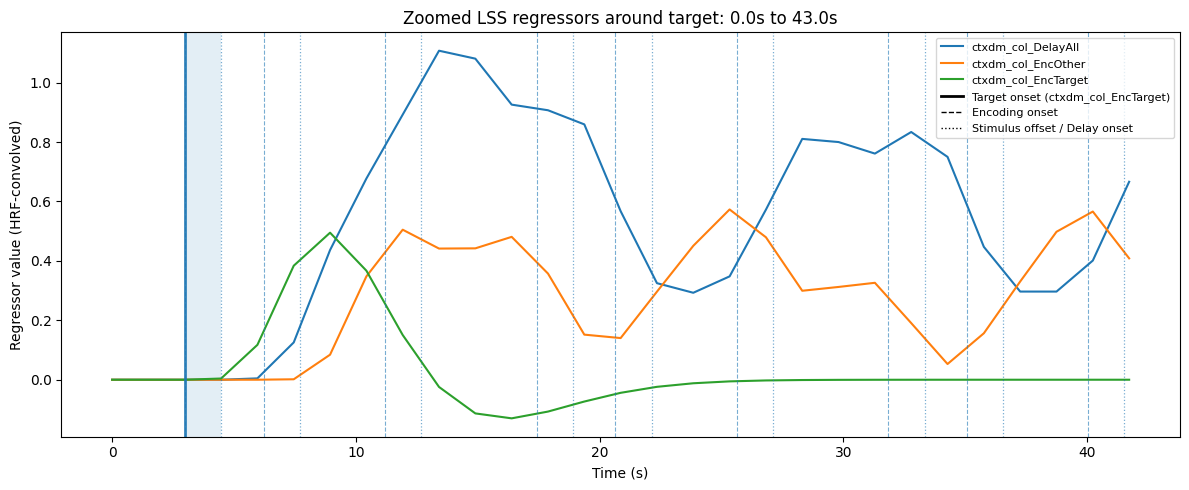

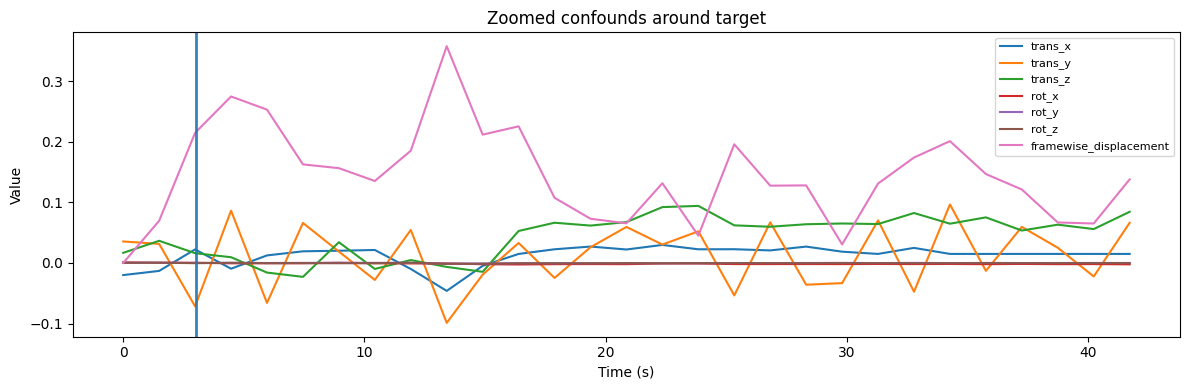

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix
from matplotlib.lines import Line2D


TR = 1.49

events_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/behav/sub-01/ses-1/events/task-ctxdm_col_run-01_LSS/task-ctxdm_col_run-01_lss-EncTarget_Enc0001_events.tsv"   # one LSS events file
confounds_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/confounds/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_desc-confounds_timeseries.tsv"

hrf_model = "glover"
high_pass = 0.01  # Hz
confound_cols = ["trans_x","trans_y","trans_z","rot_x","rot_y","rot_z"]
add_fd = True

# window around target (seconds)
pre_s = 20.0
post_s = 40.0


# ---------- load ----------
events = pd.read_csv(events_tsv, sep="\t")[["onset","duration","trial_type"]].copy()
conf = pd.read_csv(confounds_tsv, sep="\t")

cols = confound_cols.copy()
if add_fd and "framewise_displacement" in conf.columns:
    cols.append("framewise_displacement")
confounds = conf[cols].fillna(0.0)

n_scans = confounds.shape[0]
frame_times = np.arange(n_scans) * TR

# ---------- design matrix ----------
X = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model=hrf_model,
    drift_model="cosine",
    high_pass=high_pass,
    add_regs=confounds.to_numpy(),
    add_reg_names=cols,
)

# ---------- find target event ----------
target_rows = events[events["trial_type"].str.contains("Target", case=False, na=False)]
if len(target_rows) != 1:
    raise ValueError(f"Expected exactly one Target row in LSS events file, found {len(target_rows)}")

target_onset = float(target_rows.iloc[0]["onset"])
target_duration = float(target_rows.iloc[0]["duration"])
target_offset = target_onset + target_duration
target_type = target_rows.iloc[0]["trial_type"]

# ---------- compute window indices ----------
t0 = max(0.0, target_onset - pre_s)
t1 = min(frame_times[-1], target_onset + post_s)

win_mask = (frame_times >= t0) & (frame_times <= t1)
t_win = frame_times[win_mask]

# ---------- choose columns to plot ----------
task_cols = [c for c in X.columns if any(k in c for k in
                                        ["EncTarget","EncOther","EncAll",
                                         "DelayTarget","DelayOther","DelayAll"])]

# optionally include confounds in the zoom view
conf_cols = [c for c in X.columns if c in cols]

# ---------- onset/offset markers in window ----------
enc_events = events[events["trial_type"].str.contains("Enc", case=False, na=False)]
enc_onsets = enc_events["onset"].to_numpy()
enc_offsets = (enc_events["onset"] + enc_events["duration"]).to_numpy()

delay_events = events[events["trial_type"].str.contains("Delay", case=False, na=False)]
delay_onsets = delay_events["onset"].to_numpy()  # these are stimulus offsets / delay onsets

# keep only markers inside window
enc_onsets = enc_onsets[(enc_onsets >= t0) & (enc_onsets <= t1)]
delay_onsets = delay_onsets[(delay_onsets >= t0) & (delay_onsets <= t1)]
enc_offsets = enc_offsets[(enc_offsets >= t0) & (enc_offsets <= t1)]


# ---------- plot: zoomed task regressors ----------
plt.figure(figsize=(12, 5))

for c in task_cols:
    plt.plot(t_win, X.loc[win_mask, c].values, label=c)

# mark encoding onsets (dashed) and delay onsets / stimulus offsets (dotted)
for x in enc_onsets:
    plt.axvline(x, linestyle="--", linewidth=0.8, alpha=0.6)
for x in delay_onsets:
    plt.axvline(x, linestyle=":", linewidth=0.9, alpha=0.6)

# highlight target onset (thicker solid) + shade its duration
plt.axvline(target_onset, linestyle="-", linewidth=2.0, alpha=0.9)
plt.axvspan(target_onset, target_offset, alpha=0.12)

# add legend entries for markers
handles, labels = plt.gca().get_legend_handles_labels()
handles += [
    Line2D([0],[0], linestyle="-", color="k", linewidth=2, label=f"Target onset ({target_type})"),
    Line2D([0],[0], linestyle="--", color="k", linewidth=1, label="Encoding onset"),
    Line2D([0],[0], linestyle=":", color="k", linewidth=1, label="Stimulus offset / Delay onset"),
]
labels += [f"Target onset ({target_type})", "Encoding onset", "Stimulus offset / Delay onset"]

plt.xlabel("Time (s)")
plt.ylabel("Regressor value (HRF-convolved)")
plt.title(f"Zoomed LSS regressors around target: {t0:.1f}s to {t1:.1f}s")
plt.legend(handles, labels, fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()


# ---------- optional: zoomed confounds ----------
plt.figure(figsize=(12, 4))
for c in conf_cols:
    plt.plot(t_win, X.loc[win_mask, c].values, label=c)
plt.axvline(target_onset, linestyle="-", linewidth=2.0, alpha=0.9)
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Zoomed confounds around target")
plt.legend(fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()

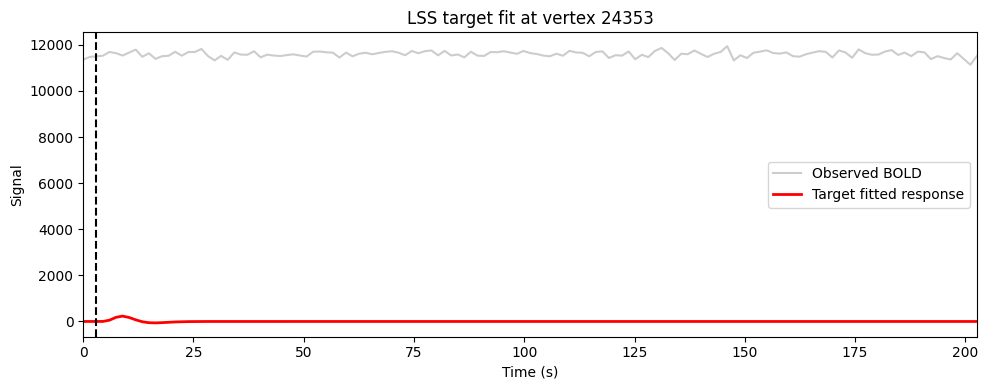

In [4]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix

TR = 1.49

# paths
dtseries_path = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/64kDense/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_space-Glasser64k_bold.dtseries.nii"
events_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/behav/sub-01/ses-1/events/task-ctxdm_col_run-01_LSS/task-ctxdm_col_run-01_lss-EncTarget_Enc0001_events.tsv"   # one LSS events file
confounds_tsv = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/confounds/sub-01/ses-01/sub-01_ses-01_task-ctxdm_acq-col_run-01_desc-confounds_timeseries.tsv"
beta_dscalar = "/mnt/tempdata/lucas/fmri/recordings/TR/neural/fmriprep_outs/first_run/glm_runs/lss/64kDense/sub-01/ses-01/task-ctxdm_acq-col_run-01/task-ctxdm_col_run-01_lss-EncTarget_Enc0001_events_beta-target.dscalar.nii"

# pick a vertex index (try a few!)
vertex = 24353

# load data
dt = nib.load(dtseries_path)
Y = dt.get_fdata().astype(float)
Y = Y if Y.shape[0] < Y.shape[1] else Y.T   # ensure (time, vertex)

beta = nib.load(beta_dscalar).get_fdata().squeeze()

events = pd.read_csv(events_tsv, sep="\t")
conf = pd.read_csv(confounds_tsv, sep="\t").fillna(0)

frame_times = np.arange(Y.shape[0]) * TR

# build design matrix (must match GLM)
X = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model="glover",
    drift_model="cosine",
    high_pass=0.01,
    add_regs=conf[[
        "trans_x","trans_y","trans_z",
        "rot_x","rot_y","rot_z"
    ]].values,
    add_reg_names=[
        "trans_x","trans_y","trans_z",
        "rot_x","rot_y","rot_z"
    ]
)

# find target regressor
target_col = [c for c in X.columns if "EncTarget" in c or "DelayTarget" in c][0]

# fitted target contribution
yhat_target = X[target_col].values * beta[vertex]

# observed data (z-scored version recommended)
y_obs = Y[:, vertex]

# plot
plt.figure(figsize=(10,4))
plt.plot(frame_times, y_obs, color="gray", alpha=0.4, label="Observed BOLD")
plt.plot(frame_times, yhat_target, color="red", linewidth=2, label="Target fitted response")
plt.axvline(events.loc[events.trial_type.str.contains("Target"),"onset"].iloc[0],
            linestyle="--", color="black")
plt.xlim(0, frame_times[-1])
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.legend()
plt.title(f"LSS target fit at vertex {vertex}")
plt.tight_layout()
plt.show()